In [164]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [165]:
def reorder(points):
    """
    Reorder the points based on following notation:
    (x_min, y_min), (x_max, y_min), (x_min, y_max), (x_max, y_max)

    :param points: The 4 points to reorder
    :return: The reordered 4 points -> dimension: (4, 1, 2)
    """
    # Squeeze to 2D matrix: (4, 1, 2) -> (4, 2)
    points = np.squeeze(points, axis=1)

    points_new = np.zeros((4, 1, 2), dtype=np.int32)

    # Add the x and y values of all 4 points
    add = points.sum(1)

    # First point, with smallest x and y coordinates
    points_new[0] = points[np.argmin(add)]

    # Last point, with largest x and y coordinates
    points_new[3] = points[np.argmax(add)]

    # Subtract the x and y values of all 4 points
    diff = np.diff(points, axis=1)

    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]

    return points_new

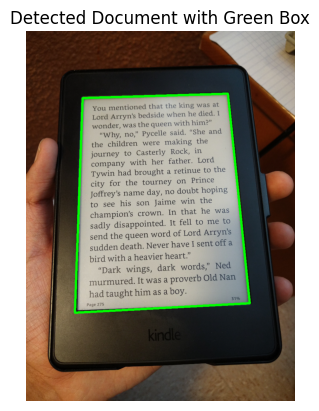

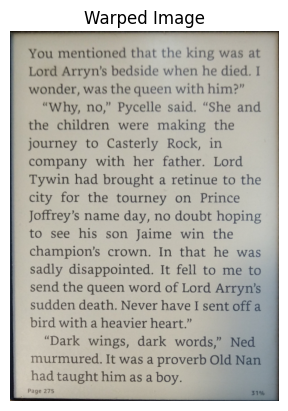

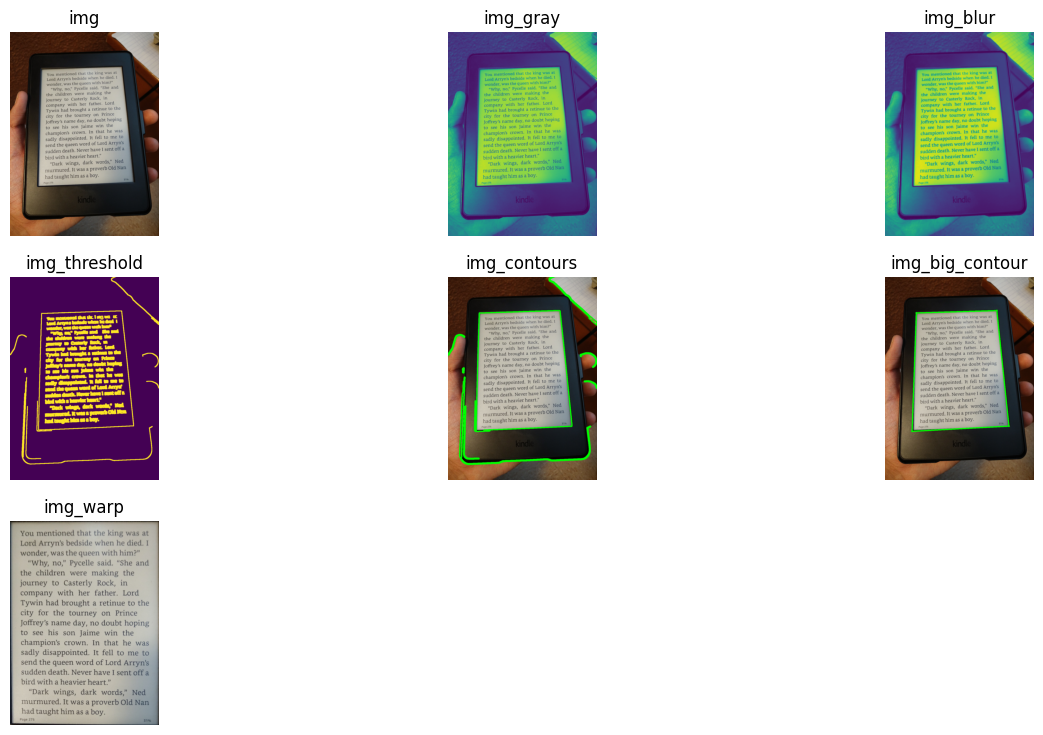

In [173]:
import cv2
import numpy as np


width = 800
height = 1100
PATH = "document.jpg"  # Path to the input image


def doc_scan_pipeline(input=PATH):
    img = cv2.imread(input)

    # 0. Convert given image from BGR to RGB format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w, _ = img.shape
    img = cv2.resize(img, (width, height))

    # 1. Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2. Add Gaussian blur
    img_blur = cv2.GaussianBlur(img_gray, (5, 5), 1)

    # 3. Add Canny edge detection
    img_threshold = cv2.Canny(img_blur, 100, 200, L2gradient=True)


    # 3.1 Apply dilation
    kernel = np.ones((3, 3))
    img_threshold = cv2.dilate(img_threshold, kernel, iterations=2)

    # 4. Find all the contours
    img_contours = img.copy()
    img_big_contour = img.copy()
    contours, hierarchy = cv2.findContours(img_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image=img_contours, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=5)
    plt.imshow(img_contours)

    #5. Find the biggest contour
    biggest_contour = np.array([])
    max_area = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        if area > max_area and len(approx) == 4:
            biggest_contour = approx
            max_area = area
    cv2.drawContours(img_big_contour,[biggest_contour],-1,(0,255,0),thickness=5)

    plt.imshow(img_big_contour)
    plt.title("Detected Document with Green Box")
    plt.axis('off')
    plt.show()

    ##6 reorder the points based on following notation:
    ##(x_min, y_min), (x_max, y_min), (x_min, y_max), (x_max, y_max)
    biggest_contour = reorder(biggest_contour)
    
    cv2.drawContours(image=img_big_contour, contours=biggest_contour, contourIdx=-1, color=(0, 255, 0), thickness=10)
    plt.imshow(img_big_contour)

    #7. image warp
    pts1 = np.float32(biggest_contour)
    pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    img_warp = cv2.warpPerspective(img, matrix, (width, height))
    plt.imshow(img_warp)
    plt.title("Warped Image")
    plt.axis('off')
    plt.imsave('scanned_img.jpg', img_warp)
    ##8.final
    imgs = [img,img_gray,img_blur,img_threshold,img_contours,img_big_contour,img_warp]
    titles = ['img','img_gray','img_blur','img_threshold','img_contours','img_big_contour','img_warp']
    plt.figure(figsize=(16,9))
    for i in range(len(imgs)):
        plt.subplot(3,3,i+1)
        plt.imshow(imgs[i])
        plt.title(titles[i])
        plt.axis('off')





if __name__ == "__main__":
    doc_scan_pipeline(input='document.jpg')
